# Austin Neighborhood Restaurant Preferences

Import libraries

In [143]:
import pandas as pd
import numpy as np
import folium 
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from matplotlib import pyplot

Load geographic data for Austin neighborhoods

In [2]:
ausgeocoord=pd.read_csv('Boundaries__Austin_Neighborhood_Planning_Areas.csv')

In [3]:
ausgeocoord.head()

,X,Y,planning_a,shape_area,label,shape_leng,_feature_i
0,-97.746431,30.340218,ALLANDALE,6.579269e+07,Allandale,42253.107210,1.0
1,-97.790368,30.252465,BARTON HILLS,8.890171e+07,Barton Hills,48353.933925,2.0
2,-97.755814,30.251534,BOULDIN CREEK,3.325900e+07,Bouldin Creek,25667.340376,3.0
3,-97.731981,30.329413,BRENTWOOD,4.420776e+07,Brentwood,29612.403698,4.0
4,-97.726068,30.270324,CENTRAL EAST AUSTIN,2.697098e+07,Central East Austin,22198.529897,5.0


Only keep the name, latitude, and longitude of neighborhoods and rename columns

In [173]:
aushoods=ausgeocoord[['label','Y','X']]
aushoods.rename(columns={'label':'neighborhood','X':'longitude','Y':'latitude'},inplace=True)
aushoods

Find the center of all of the locations to center the map

In [6]:
latitude=aushoods['latitude'].mean()
longitude=aushoods['longitude'].mean()
[latitude,longitude]

[30.281595687735546, -97.73421148955242]

Plot the neighborhoods on a map to verify coordinates

In [7]:
ausmap=folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(aushoods['latitude'], aushoods['longitude'], aushoods['neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ausmap)  
    
ausmap

Enter credentials for Foursqaure API

In [8]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define function to get restaurant categories within 1600m of each location

In [9]:
def getNearbyRestCats(neighborhoods, latitudes, longitudes):
    radius=1600
    venues_list=[]
    category='4d4b7105d754a06374d81259'
    for name, lat, lng in zip(neighborhoods, latitudes, longitudes):
           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Restaurant Category']
    
    return(nearby_venues)

Get all of the restaurant categories for each location

In [10]:
rests = getNearbyRestCats(aushoods['neighborhood'],aushoods['latitude'], aushoods['longitude'])

Remove ambiguous restaurant categories

In [11]:
rests=rests[~rests['Restaurant Category'].isin(['Food Truck','Restaurant','Food','Food Stand','Cafeteria'])]

In [12]:
rests

,Neighborhood,Restaurant Category
0,Allandale,New American Restaurant
1,Allandale,Pizza Place
4,Allandale,Thai Restaurant
5,Allandale,Mexican Restaurant
6,Allandale,Asian Restaurant
...,...,...
3901,Zilker,Café
3906,Zilker,Thai Restaurant
3907,Zilker,Snack Place
3909,Zilker,Italian Restaurant


Verify restaurant categories across all neighborhoods

In [169]:
rests.groupby('Restaurant Category').count().sort_values('Neighborhood',ascending=0)

,Neighborhood
Restaurant Category,
Mexican Restaurant,482
Sandwich Place,231
Pizza Place,229
Taco Place,191
Fast Food Restaurant,190
...,...
Argentinian Restaurant,2
Cantonese Restaurant,1
Szechuan Restaurant,1


In [152]:
restsmost=rests.groupby('Restaurant Category').count()[rests.groupby('Restaurant Category').count()['Neighborhood']>50].sort_values('Neighborhood',ascending=0)['Neighborhood'].index.tolist()

In [107]:
rests[rests['Restaurant Category'].isin(restsmost)]

,Neighborhood,Restaurant Category
0,Allandale,New American Restaurant
1,Allandale,Pizza Place
4,Allandale,Thai Restaurant
5,Allandale,Mexican Restaurant
6,Allandale,Asian Restaurant
...,...,...
3899,Zilker,American Restaurant
3900,Zilker,Mexican Restaurant
3901,Zilker,Café
3906,Zilker,Thai Restaurant


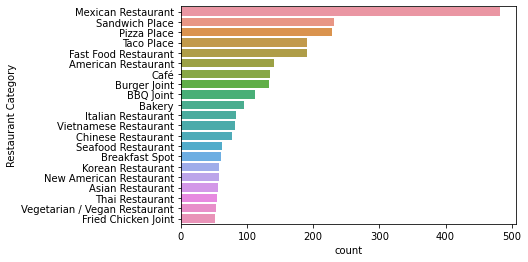

In [136]:
g=sns.countplot(y='Restaurant Category',data=rests[rests['Restaurant Category'].isin(restsmost)], order=restsmost)

Verify number of restaurants in each neighborhood

In [116]:
rests.groupby('Neighborhood').count().sort_values('Restaurant Category',ascending=0)

,Restaurant Category
Neighborhood,
North University,95
UT,92
Downtown,88
North Burnet,87
West University,87
...,...
MLK-183,7
West Austin Neighborhood Group,6
East Oak Hill,4


In [151]:
hoodsmost=rests.groupby('Neighborhood').count()[rests.groupby('Neighborhood').count()['Restaurant Category']>1].sort_values(by='Restaurant Category',ascending=0).index.tolist()

<AxesSubplot:xlabel='count', ylabel='Neighborhood'>

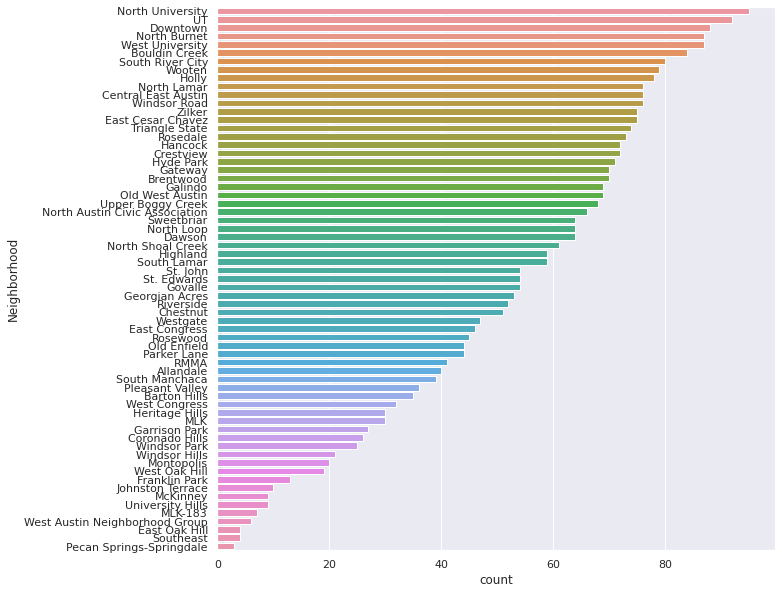

In [144]:
fig, ax = pyplot.subplots(figsize=(10,10))
sns.countplot(y='Neighborhood',data=rests,order=hoodsmost,ax=ax)

One hot encode restaurant categories

In [14]:
neighborhood_onehot = pd.get_dummies(rests['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['Neighborhood'] = rests['Neighborhood'] 
neighborhood_onehot=neighborhood_onehot[['Neighborhood']+[col for col in neighborhood_onehot if col != 'Neighborhood']]
neighborhood_onehot

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allandale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allandale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allandale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,Allandale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Allandale,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,Zilker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3906,Zilker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3907,Zilker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3909,Zilker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group by neighborhood and sum number of restaurants for each category

In [170]:
neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').sum().reset_index()
neighborhood_grouped

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allandale,0,1,0,3,1,0,4,0,0,...,0,0,2,0,0,0,1,0,0,0
1,Barton Hills,1,1,0,1,0,0,1,0,0,...,0,0,5,0,1,1,0,1,0,0
2,Bouldin Creek,0,4,0,0,5,0,1,0,0,...,1,0,4,0,2,0,2,3,1,0
3,Brentwood,0,1,0,1,2,1,3,0,0,...,1,0,4,0,0,0,3,1,1,0
4,Central East Austin,0,3,0,1,5,1,0,0,0,...,0,0,4,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Windsor Hills,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,0,0,0
61,Windsor Park,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,1,0,0
62,Windsor Road,0,4,0,2,3,1,2,0,0,...,2,0,4,0,0,0,3,1,2,1
63,Wooten,0,2,0,1,1,0,2,0,0,...,1,0,7,0,0,1,2,0,8,1


Prepare dataset for clustering algorithm

In [145]:
neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood', 1)

Use elbow method to determine optimal k

In [148]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(neighborhood_grouped_clustering)
    neighborhood_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

<AxesSubplot:>

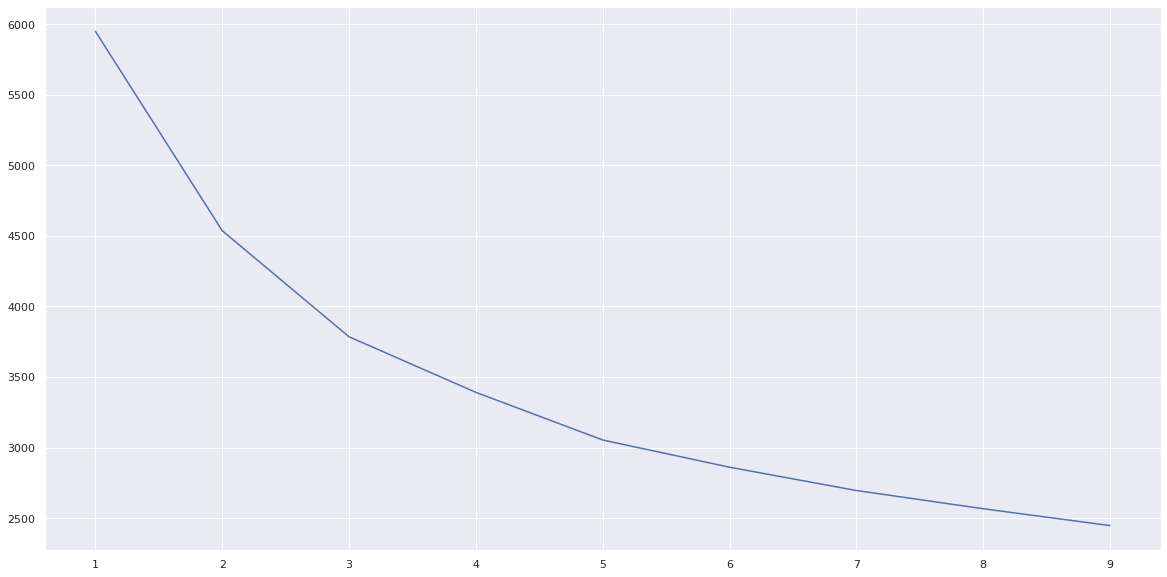

In [150]:
sns.lineplot(data=sse)

Use k value of 5 and perform clustering

In [175]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

Add cluster values to neighborhoods

In [186]:
aushoods=ausgeocoord[['label','Y','X']]
aushoods.rename(columns={'label':'neighborhood','X':'longitude','Y':'latitude'},inplace=True)
aushoods.insert(0, 'Cluster Labels', kmeans.labels_)

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [187]:
aushoods

,Cluster Labels,neighborhood,latitude,longitude
0,3,Allandale,30.340218,-97.746431
1,3,Barton Hills,30.252465,-97.790368
2,1,Bouldin Creek,30.251534,-97.755814
3,1,Brentwood,30.329413,-97.731981
4,1,Central East Austin,30.270324,-97.726068
...,...,...,...,...
60,0,Westgate,30.224844,-97.797951
61,0,Windsor Park,30.308905,-97.690085
62,4,Windsor Road,30.298798,-97.752740
63,2,Wooten,30.360237,-97.723255


In [178]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(aushoods['latitude'], aushoods['longitude'], aushoods['neighborhood'], aushoods['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [183]:
neighborhood_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [184]:
neighborhood_grouped

,Cluster Labels,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,...,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,3,Allandale,0,1,0,3,1,0,4,0,...,0,0,2,0,0,0,1,0,0,0
1,3,Barton Hills,1,1,0,1,0,0,1,0,...,0,0,5,0,1,1,0,1,0,0
2,1,Bouldin Creek,0,4,0,0,5,0,1,0,...,1,0,4,0,2,0,2,3,1,0
3,1,Brentwood,0,1,0,1,2,1,3,0,...,1,0,4,0,0,0,3,1,1,0
4,1,Central East Austin,0,3,0,1,5,1,0,0,...,0,0,4,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0,Windsor Hills,0,0,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,0,0
61,0,Windsor Park,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,1,0,0
62,4,Windsor Road,0,4,0,2,3,1,2,0,...,2,0,4,0,0,0,3,1,2,1
63,2,Wooten,0,2,0,1,1,0,2,0,...,1,0,7,0,0,1,2,0,8,1


In [185]:
for i in range(kclusters):
    curcluster=neighborhood_grouped[neighborhood_grouped['Cluster Labels'] == i].drop(['Cluster Labels','Neighborhood'], 1)
    restnums=(curcluster.mean())
    restavgs=curcluster.sum()/(curcluster.sum().sum())
    print('\nCluster ',i)
    print(pd.DataFrame([restnums,restavgs]).transpose().sort_values(0,ascending=False).rename(columns={0:'Avg',1:'%'}).head(5))


Cluster  0
                           Avg         %
Mexican Restaurant    2.888889  0.171053
Fast Food Restaurant  2.055556  0.121711
Pizza Place           1.555556  0.092105
Taco Place            1.000000  0.059211
Sandwich Place        0.944444  0.055921

Cluster  1
                           Avg         %
Mexican Restaurant   10.333333  0.133813
Pizza Place           5.222222  0.067626
BBQ Joint             4.333333  0.056115
American Restaurant   3.666667  0.047482
Burger Joint          3.555556  0.046043

Cluster  2
                            Avg         %
Mexican Restaurant    11.789474  0.207600
Taco Place             3.736842  0.065802
Pizza Place            3.684211  0.064875
Fast Food Restaurant   3.631579  0.063948
Sandwich Place         3.368421  0.059314

Cluster  3
                           Avg         %
Mexican Restaurant    5.444444  0.108889
Fast Food Restaurant  3.777778  0.075556
Sandwich Place        3.333333  0.066667
Pizza Place           3.111111  0.062222
Tac